# Exploratory data analysis

In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. For homework, you will work on this entire notebook for your own targets. Download your target related data from the following databases:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/


## Mount your drive where you have the Columbia_E4511 **folder**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Install packages** 

In [2]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-04-15 05:34:47--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   239MB/s    in 2.1s    

2021-04-15 05:34:49 (239 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navi

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge
    bravado-core-5.17.0        |

# Load Libraries

In [3]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# manipulate data
import pandas as pd

import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

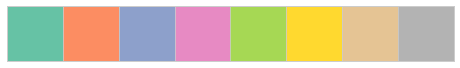

In [4]:
sns.palplot(pal)

In [5]:
! pip install molvs

In [6]:
! pip install bravado

  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18120 sha256=d297cd72387814d935ffff1434160b9a9911f5cc39f2fde4b20023b523c2bfa9
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339


In [7]:
! pip install umap

  Created wheel for umap: filename=umap-0.1.1-cp37-none-any.whl size=3568 sha256=02f8cb7c9dc4849e18426cb4535fa8b55ef846472afcbdc5eb2b8a8ae2019217
  Stored in directory: /root/.cache/pip/wheels/7b/29/33/b4d917dc95f69c0a060e2ab012d95e15db9ed4cc0b94ccac26
Successfully built umap


In [8]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

# Download/Load data

In [9]:
! wget https://raw.githubusercontent.com/ShuluFu/4511SF3038/main/MAOA-DTC2.csv
! wget https://raw.githubusercontent.com/ShuluFu/4511SF3038/main/MAOA-ExCAPE-DB-out.csv
! wget https://raw.githubusercontent.com/ShuluFu/4511SF3038/main/MAOA-chEMBL.csv

--2021-04-15 05:42:09--  https://raw.githubusercontent.com/ShuluFu/4511SF3038/main/MAOA-DTC2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3560924 (3.4M) [text/plain]
Saving to: ‘MAOA-DTC2.csv’

MAOA-DTC2.csv       100%[===================>]   3.40M  --.-KB/s    in 0.1s    

2021-04-15 05:42:10 (29.2 MB/s) - ‘MAOA-DTC2.csv’ saved [3560924/3560924]

--2021-04-15 05:42:10--  https://raw.githubusercontent.com/ShuluFu/4511SF3038/main/MAOA-ExCAPE-DB-out.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138149 (135K) [text/plain

# Explore and examine **data**

In [10]:
dtc = pd.read_csv("MAOA-DTC2.csv", sep=',', header=0, encoding='latin-1')
excape = pd.read_csv("MAOA-ExCAPE-DB-out.csv", sep=',', header=0)
chembl = pd.read_csv("MAOA-chEMBL.csv", sep=',', header=0 )

In [11]:
dtc.iloc[1:3,1:10]

,Uniprot ID,Compound Name,Standard inchi key,Max Phase,Target Pref Name,Gene Names,Target Class,Wild type or mutant,Mutation information
1,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN
2,P21397,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN


In [12]:
excape.iloc[1:3, 1:15]

,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
1,CHEMBL534467,29253,N,4.36,chembl20,306631,10116,MAOA,2549,C1(=C(N(C)C)C=NC=C1NC)CN
2,CHEMBL161985,29253,A,6.70,chembl20,305534,10116,MAOA,2549,C1=C(C=CC(CC(N)C)=C1)OCC


In [13]:
chembl.iloc[1:3, 1:10]

,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation
1,NaN,0,335.32,0,3.14,29,O=C(O)/C=C/c1ccc2oc(C(=O)Nc3ccccc3)cc(=O)c2c1,Inhibition,NaN
2,NaN,0,317.52,1,5.27,14,CCC(C)(C)c1ccc(OCCCCN2CCCC(C)C2)cc1,Inhibition,NaN


## **Examine and clean data** 
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- Think about how we might combine these data sources together

In [14]:
# get rid of spaces
chembl.columns = chembl.columns.str.replace(' ','_') 
dtc.columns = dtc.columns.str.replace(' ','_') 
excape.columns = excape.columns.str.replace(' ','_') 


print(chembl.shape)
print(dtc.shape)
print(excape.shape)

(8494, 45)
(6561, 43)
(1126, 11)


### Questions to ask while exploring data

- what molecular (and other) identifiers exist for compounds from each database?
- what assay response types are there in each file?
- think about how we might combine these data sources together

## ChEMBL: Explore `dataset`

In [15]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4283189,NaN,0,468.94,0,4.6,12b,CCN(CC)CCOC(=O)/C=C/c1ccc2oc(C(=O)Nc3cccc(Cl)c...,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4268516,Inhibition of human recombinant microsomal MAO...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4265951,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
1,CHEMBL4279249,NaN,0,335.32,0,3.14,29,O=C(O)/C=C/c1ccc2oc(C(=O)Nc3ccccc3)cc(=O)c2c1,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4268516,Inhibition of human recombinant microsomal MAO...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4265951,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
2,CHEMBL4300905,NaN,0,317.52,1,5.27,14,CCC(C)(C)c1ccc(OCCCCN2CCCC(C)C2)cc1,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4329063,Inhibition of human MAO-A expressed in baculov...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4325892,1,Scientific Literature,Bioorg Med Chem Lett,2018.0,None,NaN
3,CHEMBL8706,CLORGILINE,0,272.18,0,3.33,Clorgiline,C#CCN(C)CCCOc1ccc(Cl)cc1Cl,IC50,'=',40.00,nM,7.4,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4321000,Inhibition of recombinant human MAOA expressed...,A,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4316606,1,Scientific Literature,Bioorg Med Chem Lett,2019.0,None,NaN
4,CHEMBL8706,CLORGILINE,0,272.18,0,3.33,Clorgyline,C#CCN(C)CCCOc1ccc(Cl)cc1Cl,Kinact,'=',0.12,/min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4325534,Irreversible inhibition of recombinant human M...,B,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4321878,1,Scientific Literature,J Med Chem,2020.0,None,NaN


In [16]:
chembl.Standard_Type.value_counts()

IC50          4633
Inhibition    1842
Ki            1459
Activity       241
Km              71
Ratio           41
TN              31
FC              30
Ratio IC50      26
K inact         20
k cat           18
k cat/Km        18
TDI             16
Vmax            14
Kinact          12
KiA             11
Vmax / Km        6
% Ctrl           3
EC50             1
Ri               1
Name: Standard_Type, dtype: int64

## DTC: Explore dataset
Explore the loaded DTC and Excape dataframes, and answer the following questions:

- Number of data points in each file?
- Molecular identifiers from each file?
- Data types from each file?
- Data units in each file?
- What is the formula to translate IC50 to pIC50?
- What other information might be useful?

In [17]:
dtc.head(3)

,ï»¿Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484105,DTCC00132413,2089752,46191
1,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484106,DTCC00132413,2089752,46191
2,CHEMBL1006,P21397,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7291225,DTCC00224760,898282,46191


In [18]:
dtc['End_Point_Standard_Type'].value_counts()

IC50          3488
KI            1639
INHIBITION     987
ACTIVITY       149
KM              71
RATIO           39
TN              31
FC              30
RATIO IC50      25
K INACT         20
K CAT           18
K CAT/KM        18
VMAX            14
KIA             11
KINACT          10
VMAX / KM        6
TDI              4
RI               1
Name: End_Point_Standard_Type, dtype: int64

#### Assay data exploration

In [19]:
len(chembl.Assay_Description.unique()) 

766

Assay data responses questions
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [20]:
chembl.head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4283189,NaN,0,468.94,0,4.6,12b,CCN(CC)CCOC(=O)/C=C/c1ccc2oc(C(=O)Nc3cccc(Cl)c...,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4268516,Inhibition of human recombinant microsomal MAO...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4265951,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
1,CHEMBL4279249,NaN,0,335.32,0,3.14,29,O=C(O)/C=C/c1ccc2oc(C(=O)Nc3ccccc3)cc(=O)c2c1,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4268516,Inhibition of human recombinant microsomal MAO...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4265951,1,Scientific Literature,Eur J Med Chem,2018.0,None,NaN
2,CHEMBL4300905,NaN,0,317.52,1,5.27,14,CCC(C)(C)c1ccc(OCCCCN2CCCC(C)C2)cc1,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4329063,Inhibition of human MAO-A expressed in baculov...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4325892,1,Scientific Literature,Bioorg Med Chem Lett,2018.0,None,NaN


In [21]:
chembl.Standard_Units.unique()

array([nan, 'nM', '/min', '%', 'nmol/min', '/M/s', 'min-1', 'uM',
       'mM-1 min-1', 'M-1 min-1', 'uM min-1', 'M min-1 M-1', 'ug.mL-1',
       'nmol/min/mg', '/min/microM'], dtype=object)

## Excape-DB: Explore dataset

In [22]:
excape.columns

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES'],
      dtype='object')

In [23]:
excape.Activity_Flag.unique()

array(['A', 'N'], dtype=object)

In [24]:
excape['DB']

0       chembl20
1       chembl20
2       chembl20
3       chembl20
4       chembl20
          ...   
1121    chembl20
1122    chembl20
1123    chembl20
1124     pubchem
1125    chembl20
Name: DB, Length: 1126, dtype: object

In [25]:
excape.shape

(1126, 11)

## **ChEMBL: Curation step** 
Change units to be the same for all responses

In [26]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

#### ChEMBL EDA
Summarize, describe, plot data for analysis

In [27]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Assay_Variant_Accession,Assay_Variant_Mutation,Source_ID,Document_Year,Standard_Value_nM
count,8494.000000,5.351000e+03,2910.000000,2839.000000,0.0,0.0,8494.000000,6690.000000,5.351000e+03
mean,0.830939,3.259976e+06,5.481921,19.202282,NaN,NaN,5.362844,2013.359193,3.260294e+06
std,1.602983,4.038578e+07,1.108875,6.881646,NaN,NaN,8.750124,5.209612,4.038576e+07
min,0.000000,-1.300000e+01,3.650000,3.880000,NaN,NaN,1.000000,1990.000000,-1.300000e+01
25%,0.000000,7.525000e+01,4.642500,14.305000,NaN,NaN,1.000000,2011.000000,7.600000e+01
50%,0.000000,5.120000e+03,5.230000,17.840000,NaN,NaN,1.000000,2014.000000,5.243700e+03
75%,0.000000,4.105000e+04,6.000000,22.405000,NaN,NaN,1.000000,2017.000000,4.123000e+04
max,4.000000,1.000000e+09,10.000000,68.920000,NaN,NaN,54.000000,2020.000000,1.000000e+09



Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries

In [28]:
chembl=chembl.replace('None',np.nan)

In [29]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

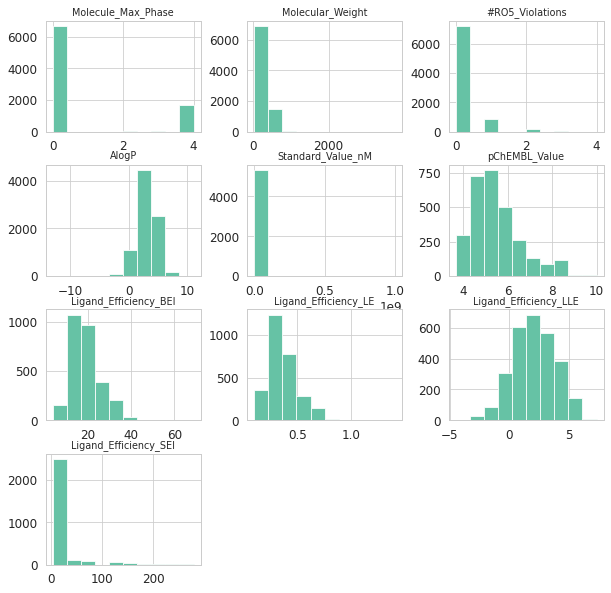

In [30]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

Standard_Type,% Ctrl,Activity,EC50,FC,IC50,Inhibition,K inact,Ki,KiA,Kinact,Km,Ratio,Ratio IC50,Ri,TN,Vmax,Vmax / Km,k cat,k cat/Km
count,3.000000,78.000000,1.0,14.000000,2.924000e+03,830.000000,9.000000,5.270000e+02,11.000000,1.000000e+01,5.700000e+01,39.000000,22.000000,1.0,26.000000,14.000000,5.000000,18.000000,18.000000
mean,77.333333,1657.530751,1600.0,0.494464,4.772394e+04,30.179454,0.442741,3.276089e+07,89.781818,1.698602e+05,2.128013e+05,19425.904103,16.272727,1.9,112.690385,202.102143,1609.200000,268.888889,1896.777778
std,43.821608,9641.943166,NaN,0.263614,1.017410e+05,23.145742,0.901265,1.249874e+08,122.922145,4.849629e+05,2.215167e+05,114158.389214,49.981122,NaN,112.228947,110.735039,2244.118357,293.093217,1451.169531
min,27.000000,-11.200000,1600.0,0.060000,7.200000e-01,-13.000000,0.001800,0.000000e+00,1.600000,2.850000e-02,1.200000e-01,0.030000,2.000000,1.9,5.210000,20.000000,76.000000,28.000000,47.000000
25%,62.500000,57.850000,1600.0,0.337500,2.782250e+03,10.000000,0.008767,6.050000e+02,9.750000,4.025000e-01,6.300000e+04,50.000000,6.000000,1.9,14.975000,185.670000,588.000000,79.000000,641.750000
50%,98.000000,71.300000,1600.0,0.445000,1.230500e+04,27.000000,0.130000,1.255333e+04,29.000000,8.750000e+03,1.300000e+05,802.000000,6.000000,1.9,95.450000,185.670000,692.000000,196.500000,1708.500000
75%,102.500000,83.150000,1600.0,0.607500,5.968250e+04,46.475000,0.290000,1.000000e+05,125.000000,2.807500e+04,3.060000e+05,1693.000000,6.000000,1.9,144.500000,185.670000,1122.000000,342.750000,2490.250000
max,107.000000,60680.000000,1600.0,1.000000,1.250000e+06,100.000000,2.800000,1.000000e+09,390.000000,1.548000e+06,1.200000e+06,714000.000000,240.000000,1.9,438.000000,526.000000,5568.000000,1292.000000,5568.000000


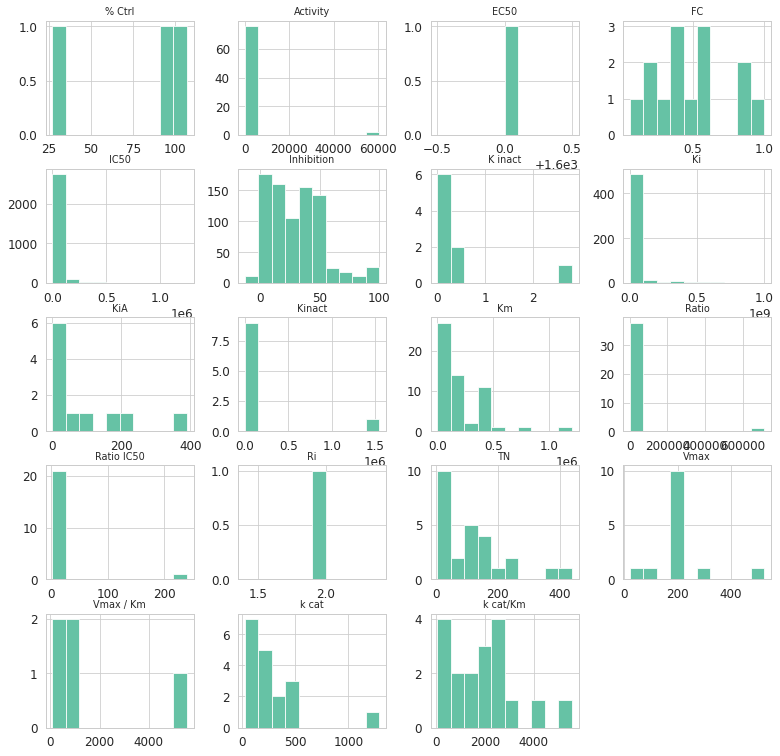

In [31]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

 What do you notice about the standard values?

Standard_Type,EC50,IC50,Ki
count,1.0,2057.000000,341.000000
mean,5.8,5.340496,5.796760
std,NaN,0.986833,1.122860
min,5.8,4.000000,4.030000
25%,5.8,4.600000,4.820000
50%,5.8,5.140000,5.613333
75%,5.8,5.840000,6.580000
max,5.8,10.000000,9.320000


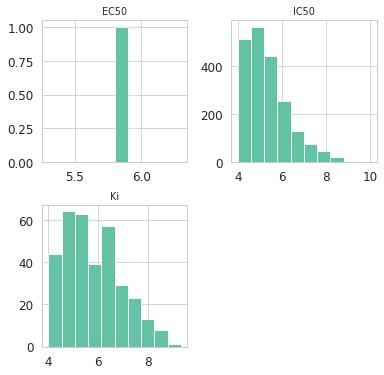

In [32]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## DTC: Curation Step
- Add pValue column from raw measurements if it doesn't exist

**

In [33]:
dtc.iloc[0:3, 0:]

,ï»¿Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484105,DTCC00132413,2089752,46191
1,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484106,DTCC00132413,2089752,46191
2,CHEMBL1006,P21397,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7291225,DTCC00224760,898282,46191


## DTC EDA

In [34]:
dtc=dtc.replace('None', np.nan)


In [35]:
dtc.head(3)

,ï»¿Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484105,DTCC00132413,2089752,46191
1,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484106,DTCC00132413,2089752,46191
2,CHEMBL1006,P21397,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7291225,DTCC00224760,898282,46191


In [36]:
dtc.End_Point_Standard_Units.unique() #already all nM

array([nan, 'NM', '%', 'NMOL/MIN/MG', '/M/S', 'MIN-1', 'M-1 MIN-1',
       'UG.ML-1', 'M MIN-1 M-1', '/MIN', 'UM MIN-1', 'MM-1 MIN-1',
       'NMOL/MIN'], dtype=object)

In [37]:
dtc.End_Point_Standard_Type.unique()

array(['IC50', 'KI', 'INHIBITION', 'KM', 'VMAX', 'ACTIVITY', 'FC',
       'RATIO', 'K INACT', 'RATIO IC50', 'TN', 'TDI', 'KINACT', 'K CAT',
       'K CAT/KM', 'KIA', 'VMAX / KM', 'RI'], dtype=object)

In [38]:
dtc[dtc.End_Point_Standard_Units=='NM'].End_Point_Standard_Type.unique()

array(['IC50', 'KI', 'KM', 'KINACT', 'KIA', 'RI'], dtype=object)

Curation step: create pValues from normal values

In [39]:
# add pX column
dtc['pDTC_Value'] = np.where(dtc.End_Point_Standard_Units == 'NM',
                             -np.log10(dtc.End_Point_Standard_Value/1000000000 ),
                             dtc.End_Point_Standard_Value)

In [40]:
dtc.describe()

,Max_Phase,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Value,Endpoint_Mode_of_Action,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Year,Volume,Issue,Annotation_Comments,Assay_ID,DTC_Activity_ID,Record_ID,DTC_Document_ID,pDTC_Value
count,6561.000000,0.0,0.0,3.821000e+03,3.949000e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4587.000000,3906.000000,3440.000000,0.0,6.329000e+03,6.561000e+03,6.561000e+03,6561.000000,3949.000000
mean,0.888279,NaN,NaN,2.147015e+07,2.058798e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.031393,35.807988,13.588372,NaN,9.368678e+05,7.876628e+06,1.078231e+06,48563.930194,244.441040
std,1.632796,NaN,NaN,4.585266e+06,3.825851e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.826955,22.483182,102.259528,NaN,3.974437e+05,4.755028e+06,6.368733e+05,13649.507869,11445.734983
min,0.000000,NaN,NaN,1.610807e+06,-1.120000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990.000000,1.000000,1.000000,NaN,9.976000e+04,1.826000e+03,5.390000e+02,1996.000000,-11.200000
25%,0.000000,NaN,NaN,2.009304e+07,2.380000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,20.000000,7.000000,NaN,7.542890e+05,3.501034e+06,5.328760e+05,45255.000000,4.301030
50%,0.000000,NaN,NaN,2.205571e+07,6.430000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,25.000000,12.000000,NaN,7.746480e+05,7.383106e+06,1.091346e+06,46191.000000,5.104025
75%,0.000000,NaN,NaN,2.456074e+07,4.055000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,51.000000,16.000000,NaN,1.349395e+06,1.295354e+07,1.644656e+06,60796.000000,6.428990
max,4.000000,NaN,NaN,2.846036e+07,1.000000e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,329.000000,5996.000000,NaN,1.576945e+06,1.475771e+07,2.110531e+06,69498.000000,714000.000000


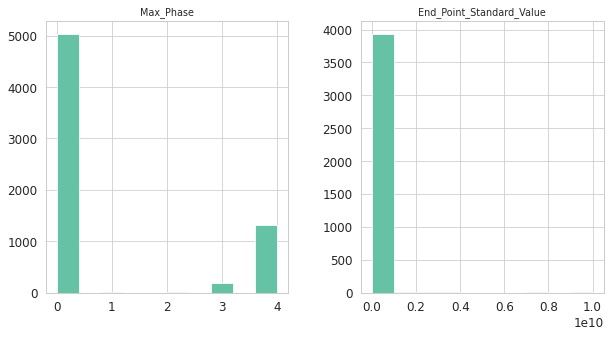

In [41]:
numeric_cols=['Max_Phase', 'End_Point_Standard_Value']
dtc[numeric_cols].hist(figsize=(10,5));

In [42]:
dtc=dtc.rename(columns={'ï»¿Compound_ID': 'Compound_ID'})

End_Point_Standard_Type,ACTIVITY,FC,IC50,INHIBITION,K CAT,K CAT/KM,K INACT,KI,KIA,KINACT,KM,RATIO,RATIO IC50,RI,TN,VMAX,VMAX / KM
count,14.000000,14.000000,1.800000e+03,337.000000,18.000000,18.000000,9.000000,5.100000e+02,11.000000,8.000000e+00,5.700000e+01,37.000000,21.000000,1.0,26.000000,14.000000,5.000000
mean,8712.075238,0.494464,4.165635e+04,33.527062,268.888889,1896.777778,0.442741,1.591378e+08,89.781818,2.123250e+05,2.128013e+05,20475.904595,16.809524,1.9,112.690385,202.102143,1609.200000
std,22015.445322,0.263614,1.015145e+05,20.423481,293.093217,1451.169531,0.901265,1.055096e+09,122.922145,5.404457e+05,2.215167e+05,117192.361214,51.150385,NaN,112.228947,110.735039,2244.118357
min,-11.200000,0.060000,7.200000e-01,-4.000000,28.000000,47.000000,0.001800,5.000000e-02,1.600000,2.850000e-02,1.200000e-01,0.030000,2.000000,1.9,5.210000,20.000000,76.000000
25%,42.900000,0.337500,1.765000e+03,18.000000,79.000000,641.750000,0.008767,8.800000e+02,9.750000,5.775030e+03,6.300000e+04,70.000000,6.000000,1.9,14.975000,185.670000,588.000000
50%,70.750000,0.445000,1.000000e+04,40.000000,196.500000,1708.500000,0.130000,1.213088e+04,29.000000,1.170000e+04,1.300000e+05,802.000000,6.000000,1.9,95.450000,185.670000,692.000000
75%,81.495000,0.607500,4.140000e+04,40.000000,342.750000,2490.250000,0.290000,1.020000e+05,125.000000,4.632500e+04,3.060000e+05,1710.000000,6.000000,1.9,144.500000,185.670000,1122.000000
max,60680.000000,1.000000,1.250000e+06,100.000000,1292.000000,5568.000000,2.800000,1.000000e+10,390.000000,1.548000e+06,1.200000e+06,714000.000000,240.000000,1.9,438.000000,526.000000,5568.000000


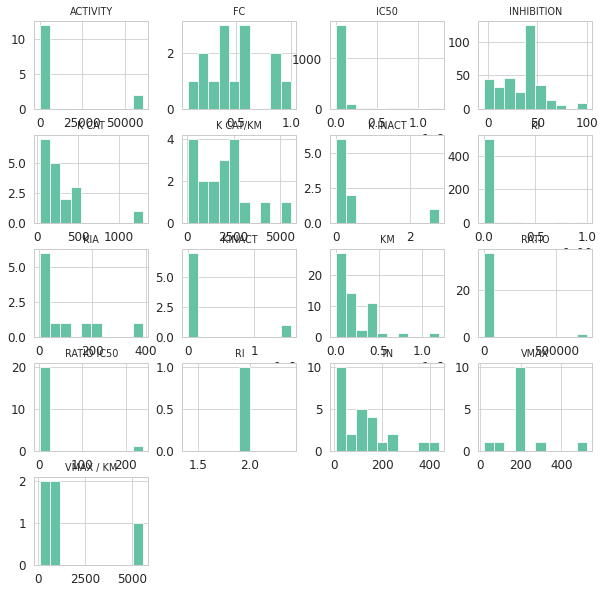

In [43]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='End_Point_Standard_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(10,10));

End_Point_Standard_Type,ACTIVITY,FC,IC50,INHIBITION,K CAT,K CAT/KM,K INACT,KI,KIA,KINACT,KM,RATIO,RATIO IC50,RI,TN,VMAX,VMAX / KM
count,14.000000,14.000000,1800.000000,337.000000,18.000000,18.000000,9.000000,510.000000,11.000000,8.000000,57.000000,37.000000,21.000000,1.000000,26.000000,14.000000,5.000000
mean,8712.075238,0.494464,5.348902,33.527062,268.888889,1896.777778,0.442741,4.675387,7.516874,3.311595,3.769355,20475.904595,16.809524,8.721246,112.690385,202.102143,1609.200000
std,22015.445322,0.263614,3.622681,20.423481,293.093217,1451.169531,0.901265,2.059709,0.764064,2.127938,0.878674,117192.361214,51.150385,NaN,112.228947,110.735039,2244.118357
min,-11.200000,0.060000,1.800000,-4.000000,28.000000,47.000000,0.001800,-1.000000,6.408935,0.028500,0.120000,0.030000,2.000000,8.721246,5.210000,20.000000,76.000000
25%,42.900000,0.337500,4.384579,18.000000,79.000000,641.750000,0.008767,3.952738,6.933231,2.137672,3.339922,70.000000,6.000000,8.721246,14.975000,185.670000,588.000000
50%,70.750000,0.445000,5.000000,40.000000,196.500000,1708.500000,0.130000,5.143427,7.537602,4.272643,3.841638,802.000000,6.000000,8.721246,95.450000,185.670000,692.000000
75%,81.495000,0.607500,5.769551,40.000000,342.750000,2490.250000,0.290000,6.006580,8.036572,4.902039,4.116025,1710.000000,6.000000,8.721246,144.500000,185.670000,1122.000000
max,60680.000000,1.000000,100.000000,100.000000,1292.000000,5568.000000,2.800000,8.443697,8.795880,5.113509,8.000000,714000.000000,240.000000,8.721246,438.000000,526.000000,5568.000000


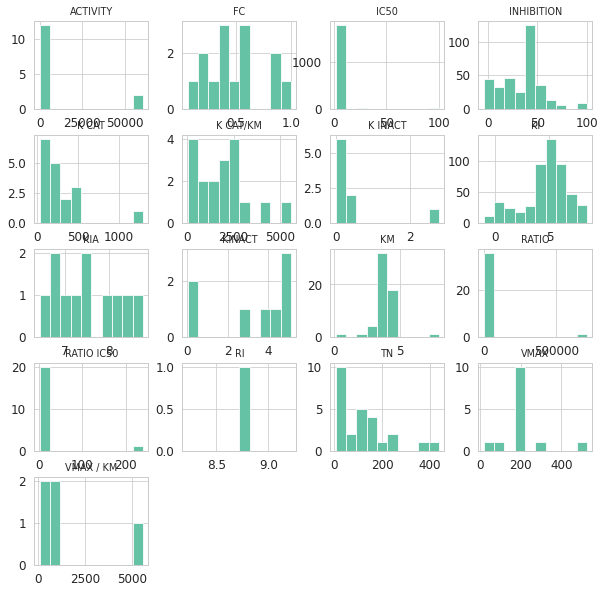

In [44]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='pDTC_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(10,10));

In [45]:
excape=excape.replace('None', np.nan)
excape.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,YZWSFMLXYJBZHX-UHFFFAOYNA-N,CHEMBL90653,29253,A,5.73,chembl20,122944,10116,MAOA,2549,C(#C)CNNCCC1=CC=CC=C1
1,AWVIXFRXKJBBDX-UHFFFAOYNA-N,CHEMBL534467,29253,N,4.36,chembl20,306631,10116,MAOA,2549,C1(=C(N(C)C)C=NC=C1NC)CN
2,CCAMEVFYMFXHEN-UHFFFAOYNA-N,CHEMBL161985,29253,A,6.70,chembl20,305534,10116,MAOA,2549,C1=C(C=CC(CC(N)C)=C1)OCC
3,BYZXZKHEDRHOEE-UHFFFAOYNA-N,CHEMBL147515,29253,N,4.17,chembl20,123102,10116,MAOA,2549,C(#C)CNCCC1=CC(O)=CC=C1
4,DBDVAKGHPZJLTH-UHFFFAOYNA-N,CHEMBL75228,4128,N,3.92,chembl20,799283,9606,MAOA,2549,C=1C=CC=CC1CCN2CCCCC2


,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,1126.000000,1108.000000,1.126000e+03,1126.000000,1126.0
mean,14035.193606,5.197642,5.635935e+05,9807.101243,2549.0
std,12284.126677,1.507646,3.469867e+05,249.349437,0.0
min,4128.000000,0.010000,9.993300e+04,9606.000000,2549.0
25%,4128.000000,4.360000,1.235800e+05,9606.000000,2549.0
50%,4128.000000,5.132450,6.106570e+05,9606.000000,2549.0
75%,29253.000000,6.065000,7.784682e+05,10116.000000,2549.0
max,29253.000000,11.310000,1.368730e+06,10116.000000,2549.0


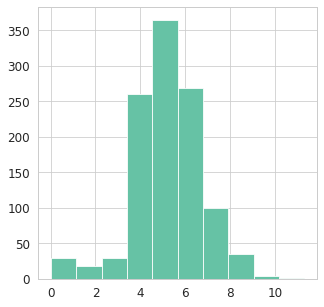

In [46]:
# excape only has one column we care about
display(excape.describe())
excape.pXC50.hist(figsize=(5,5));

# Compare pResponse values across ChEMBL, DTC and Excape-DB
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

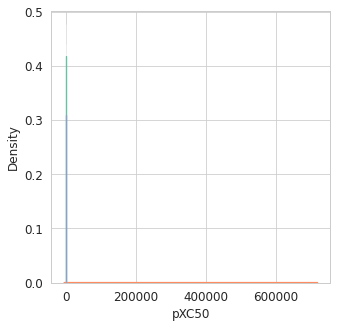

In [47]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(chembl.pChEMBL_Value, ax=ax)
sns.distplot(dtc.pDTC_Value, ax=ax)
sns.distplot(excape.pXC50, ax=ax);

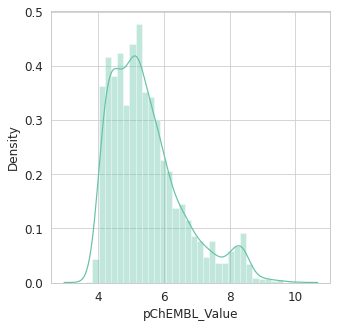

In [48]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(chembl.pChEMBL_Value, ax=ax)

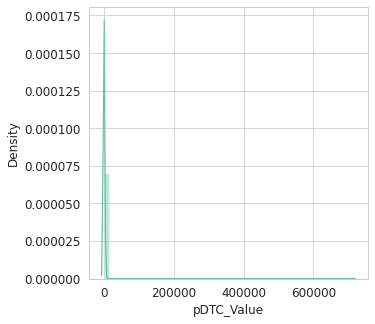

In [49]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(dtc.pDTC_Value, ax=ax)

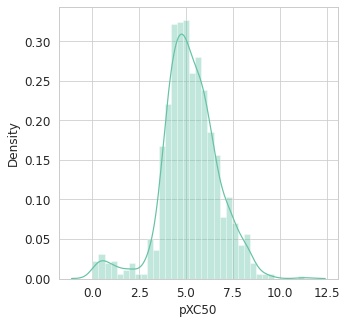

In [50]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(excape.pXC50, ax=ax);

# Analysis
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

<p> I would model either pXC50 or pKI values. They are the most abundant in the dataset and commonly used for modeling. pKI is more normally distributed, but pXC50 values allow inclusion of excape data. 

According to some sources, these two datapoints can be combined in various ways, as well, but that's beyond the scope of this class.

I would choose a reasonable IC50 concentration to use as a threshold (perhaps 10uM, or consult with a scientist), and anything with an IC50 above that threshold is inactive (you need more drug to get activity) and IC50s below this threshold is active (you need less drug for activity, meaning the compound is MORE active per unit)

## EDA tips
- Make sure smiles strings exist since that's what AMPL uses
- Compare compounds in each dataset
- Featurize with ECFP fingerprints
- Examine diversity of compound set

# **Final Curation** **bold text** 




Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets/excel or from the LHS folder menu, right-click on the "HTR3A_DTC.csv" file to download it to your computer and open the file with Excel. 
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi  (use highlight and click on "Follow-link" option to open the link in your browser)
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

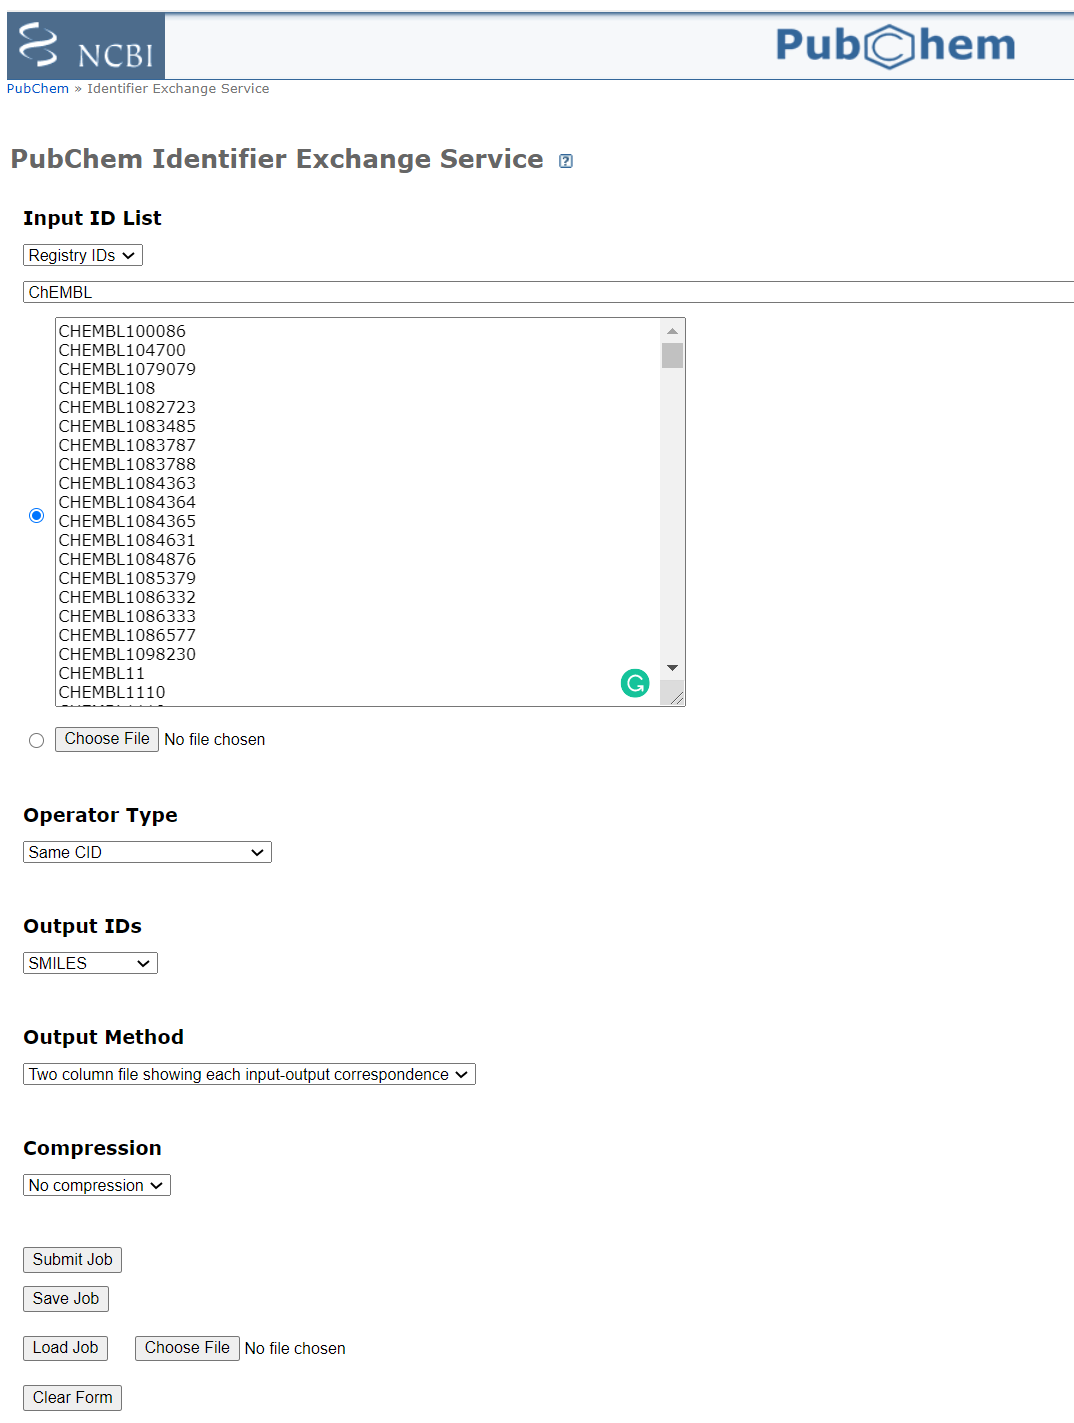

In [51]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/Img/PubChemCIDExchange.png", 
      width = 900, height = 900)

Note, the output from PubChem Identifier Exchange Service can be uploaded into the left hand window of COLAB by dragging and dropping the file. In my case the output file is, `3983437898785642818.txt`

In my case, I have saved the file in Google Drive and I am loading it in the following code chunk 

In [52]:
# open file from pubchem ID exchange service
# dtc_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/3983437898785642818.txt", sep="\t", header=None)

In [53]:
# the file is also available from my Github link 
! wget https://raw.githubusercontent.com/ShuluFu/4511SF3038/main/Idexchange.txt

--2021-04-15 05:42:34--  https://raw.githubusercontent.com/ShuluFu/4511SF3038/main/Idexchange.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254584 (249K) [text/plain]
Saving to: ‘Idexchange.txt’

Idexchange.txt      100%[===================>] 248.62K  --.-KB/s    in 0.01s   

2021-04-15 05:42:34 (22.4 MB/s) - ‘Idexchange.txt’ saved [254584/254584]



In [54]:
# uncomment if you want to acess the files 
dtc_smiles = pd.read_csv("Idexchange.txt", sep='\t', header=None)
dtc_smiles.head(3)

,0,1
0,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
1,CHEMBL1006,C(CN)CNCCSP(=O)(O)O
2,CHEMBL1009,C1=CC(=C(C=C1C[C@@H](C(=O)O)N)O)O


In [55]:
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
1,CHEMBL1006,C(CN)CNCCSP(=O)(O)O
2,CHEMBL1009,C1=CC(=C(C=C1C[C@@H](C(=O)O)N)O)O
3,CHEMBL101,CCCCC1C(=O)N(N(C1=O)C2=CC=CC=C2)C3=CC=CC=C3
4,CHEMBL101168,C1=CC=C2C(=C1)N=NN2N


In [56]:
dtc[['Compound_ID']].head(3)

,Compound_ID
0,CHEMBL10
1,CHEMBL10
2,CHEMBL1006


#### Let us explore the `map(dict(zip()))` construct

In [57]:
# code from https://stackoverflow.com/questions/209840/how-do-i-convert-two-lists-into-a-dictionary;
# var names were modified
mykeys = ['a', 'b', 'c']
myvalues = [1, 2, 3]
mydict = dict(zip(mykeys, myvalues))
print(mydict) # {'a': 1, 'b': 2, 'c': 3}

{'a': 1, 'b': 2, 'c': 3}


In [58]:
import pandas as pd
s = pd.Series(['cat', 'dog', np.nan, 'rabbit'])
s.map({'cat': 'kitten', 'dog': 'puppy'})

0    kitten
1     puppy
2       NaN
3       NaN
dtype: object

In [59]:
dtc_smiles[0:3]

,ChEMBL_ID,SMILES
0,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
1,CHEMBL1006,C(CN)CNCCSP(=O)(O)O
2,CHEMBL1009,C1=CC(=C(C=C1C[C@@H](C(=O)O)N)O)O


In [60]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['Compound_ID'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [61]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['Compound_ID'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 160
No SMILES from ChemblID in DTC: 241


**

No SMILES for 160 compounds that had ChEMBL IDs. They are 

      Compound_ID	 Standard_inchi_key        	               SMILES



Another 241 of them had no ChEMBL IDs 


In [62]:
# if you want to explore the data outside of COLAB
#  dtc.to_csv("test.csv")

#### For the missing Compound IDs, let us try to recover the SMILES from InChi Keys

In [63]:
dtc[dtc.SMILES.isna()]['Standard_inchi_key'].unique().tolist()

[nan,
 'OLESAACUTLOWQZ-UHFFFAOYSA-L',
 'IHIXIJGXTJIKRB-UHFFFAOYSA-N',
 'MQXVYODZCMMZEM-XKNYDFJKSA-N',
 'VQOXZBDYSJBXMA-VHFLTRTASA-N',
 'VZRHWAMVYGJKJC-UHFFFAOYSA-N',
 'KPFBXHILSAQXQJ-UHFFFAOYSA-N',
 'KUGXDPBCWAJMSS-UHFFFAOYSA-N',
 'ZROHGHOFXNOHSO-BNTLRKBRSA-L',
 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
 'MHGHKCBKUYUBGT-UHFFFAOYSA-N',
 'QDBXCEYPCFJLAZ-UHFFFAOYSA-N',
 'FENPZWPZPMHHIN-UHFFFAOYSA-N',
 'YQKHTAYRNHDUJE-PKNBQFBNSA-N',
 'CNKLGZVWUGSORN-UHFFFAOYSA-N',
 'VOOIVILQOWPJQS-UHFFFAOYSA-N',
 'SQKDIBYWOIDSOX-ZRDIBKRKSA-N',
 'OXZYMNOEEYRVIS-UHFFFAOYSA-N',
 'FPJVNUKARWLDBQ-UHFFFAOYSA-N',
 'NRVDUSQWCOCYMS-UHFFFAOYSA-N',
 'IDWQAHRSNRIGPK-UHFFFAOYSA-N',
 'DSHRIDMCHQEZIA-UHFFFAOYSA-N',
 'CQFGSDLIRKFROE-UHFFFAOYSA-N',
 'DRKPGLZLXFUQLA-UHFFFAOYSA-N',
 'HXYCOMWEFPNMSP-UHFFFAOYSA-N',
 'SIQZCJMPRPDTSE-UHFFFAOYSA-N',
 'IRWSGBFEWYRZGP-UHFFFAOYSA-N',
 'ALHYVZBAFYDLIJ-UHFFFAOYSA-N',
 'ZQUHYMHHSALAJU-UHFFFAOYSA-N',
 'NIJUSBFWIMOEIS-UHFFFAOYSA-N',
 'UCAONOPVOXJPQZ-MDWZMJQESA-N',
 'WDUMAABHELTPCT-UHFFFAOYSA-N',
 '

The file 12345.txt is the output from NCBI ID Exchange using the above 29 InChi keys as input

In [64]:
dtc.head(2)

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES
0,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484105,DTCC00132413,2089752,46191,NaN,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
1,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484106,DTCC00132413,2089752,46191,NaN,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...


In [65]:
inchi_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/12345.txt", sep='\t', header=None)


In [66]:
# if you havent completed the conversion, you can access the file from my GitHub link
inchi_smiles.head(3)

,0,1
0,OLESAACUTLOWQZ-UHFFFAOYSA-L,C1CC(C1)(C(=O)[O-])C(=O)[O-].N.N.[Pt+2]
1,IHIXIJGXTJIKRB-UHFFFAOYSA-N,[O-][V](=O)([O-])[O-].[Na+].[Na+].[Na+]
2,IHIXIJGXTJIKRB-UHFFFAOYSA-N,[O-][V](=O)([O-])[O-].[Na+].[Na+].[Na+]


In [67]:
inchi_smiles=inchi_smiles.rename(columns = {0:'INCHIKEY',1:'SMILES'})
inchi_smiles

,INCHIKEY,SMILES
0,OLESAACUTLOWQZ-UHFFFAOYSA-L,C1CC(C1)(C(=O)[O-])C(=O)[O-].N.N.[Pt+2]
1,IHIXIJGXTJIKRB-UHFFFAOYSA-N,[O-][V](=O)([O-])[O-].[Na+].[Na+].[Na+]
2,IHIXIJGXTJIKRB-UHFFFAOYSA-N,[O-][V](=O)([O-])[O-].[Na+].[Na+].[Na+]
3,MQXVYODZCMMZEM-XKNYDFJKSA-N,NaN
4,VQOXZBDYSJBXMA-VHFLTRTASA-N,C[C@H]1/C=C/C=C/CC/C=C/C=C/C=C/C=C/[C@@H](C[C@...
...,...,...
41,TVLJTLQCDJYBBE-KPKJPENVSA-N,C\1C2=CC=CC=C2C(=O)/C1=C/C3=CSC=C3
42,UTUPQHXDVDJNQY-UHFFFAOYSA-N,CC1=C(C=C(C=C1)NC(=O)CCC(=O)OCC(=O)C2=CC=C(C=C...
43,MVQSGAHWADNELM-UHFFFAOYSA-N,C1=CC=C2C=C(C=CC2=C1)OC3=CC(=C(C=C3)C#N)C#N
44,JZMPMMSEDRXFLV-UHFFFAOYSA-N,CC(=O)N1CCC(=N1)C2=CC=C(C=C2)Cl


In [68]:
dtc['SMILES'].isna().sum()
dtc['Standard_inchi_key'].isnull().sum()
dtc['SMILES'].isnull().sum()
dtc['SMILES'].head(3)

0    CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
1    CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
2                                  C(CN)CNCCSP(=O)(O)O
Name: SMILES, dtype: object

In [69]:
my_dict = dict(zip( inchi_smiles.INCHIKEY, inchi_smiles.SMILES))
dtc['SMILES1'] = dtc['Standard_inchi_key'].map(my_dict)

In [70]:
# checking

print(dtc['SMILES'].isna().sum())
print(chembl['Smiles'].isna().sum())
print(excape['SMILES'].isna().sum())


241
64
0


In [71]:
dtc['SMILES']= np.where(dtc['SMILES'].isnull(), dtc['SMILES1'], dtc['SMILES'])

In [72]:
dtc = dtc.drop(['SMILES1'], axis=1)

In [73]:
dtc=dtc.replace('None', np.nan)

# EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

In [74]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

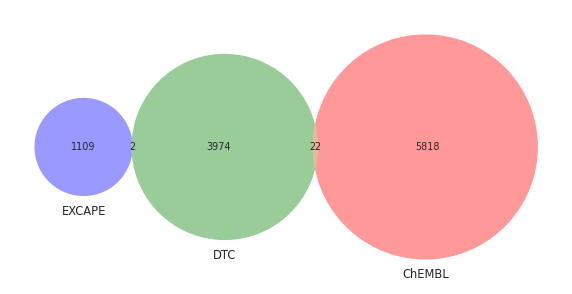

In [75]:
# overlaps from SMILES strings
venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

### venn diagram 

For overlapping ChEMBL IDs - mpv requires sets not lists

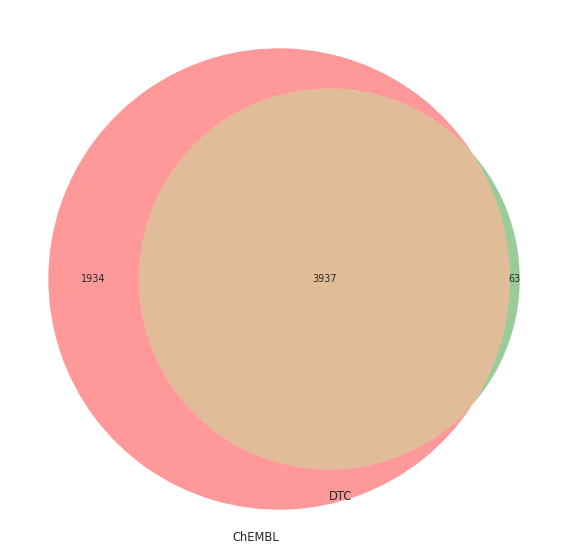

In [76]:
venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.Compound_ID)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

# **Curation step:** Standardize smiles strings, drop rows without base smiles

In [77]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

8494
5840
5814


In [78]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
99,CHEMBL1458880,CADMIUM DICHLORIDE,0.0,183.32,NaN,NaN,CADMIUM CHLORIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,
327,CHEMBL508338,THIMEROSAL,4.0,404.82,NaN,NaN,THIMEROSAL,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,
388,CHEMBL1909057,COPPER(II) OXIDE,0.0,79.55,NaN,NaN,COPPER(II) OXIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,
465,CHEMBL1909083,ZIRCONIUM(IV) CHLORIDE,0.0,233.04,NaN,NaN,ZIRCONIUM(IV) CHLORIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,
584,CHEMBL1909083,ZIRCONIUM(IV) CHLORIDE,0.0,233.04,NaN,NaN,ZIRCONIUM(IV) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7460,CHEMBL306043,GOLD SODIUM THIOMALATE,4.0,346.11,NaN,NaN,GOLD SODIUM THIOMALATE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,
7732,CHEMBL136478,SODIUM NITROPRUSSIDE,4.0,261.92,NaN,NaN,SODIUM NITROPRUSSIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,
7738

In [79]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
99,CHEMBL1458880,CADMIUM DICHLORIDE,0.0,183.32,NaN,NaN,CADMIUM CHLORIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,NaN
327,CHEMBL508338,THIMEROSAL,4.0,404.82,NaN,NaN,THIMEROSAL,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,NaN
388,CHEMBL1909057,COPPER(II) OXIDE,0.0,79.55,NaN,NaN,COPPER(II) OXIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,NaN
465,CHEMBL1909083,ZIRCONIUM(IV) CHLORIDE,0.0,233.04,NaN,NaN,ZIRCONIUM(IV) CHLORIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,NaN
584,CHEMBL1909083,ZIRCONIUM(IV) CHLORIDE,0.0,233.04,NaN,NaN,ZIRCONIUM(IV) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7460,CHEMBL306043,GOLD SODIUM THIOMALATE,4.0,346.11,NaN,NaN,GOLD SODIUM THIOMALATE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN,NaN
7732,CHEMBL136478,SODIUM NITROPRUSSIDE,4.0,261.92,NaN,NaN,SODIUM NITROPRUSSIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909169,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL383

In [80]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

In [81]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles


## Standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [82]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
dtc=dtc.replace('',np.nan)
dtc[dtc.base_rdkit_smiles.isna()]

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles
214,CHEMBL1200431,P21397,GADOPENTETATE DIMEGLUMINE,NaN,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7331439,DTCC00678414,1544899,46191,NaN,NaN,NaN
215,CHEMBL1200431,P21397,GADOPENTETATE DIMEGLUMINE,NaN,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7331440,DTCC00678414,1544899,46191,NaN,NaN,NaN
216,CHEMBL1200528,P21397,CHROMIC CHLORIDE,NaN,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7371342,DTCC00678493,1447878,46191,NaN,NaN,NaN
217,CHEMBL1200528,P21397,CHROMIC CHLORIDE,NaN,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7371343,DTCC00678493,1447878,46191,NaN,NaN,NaN
242,CHEMBL1200693,P21397,MANGANESE CHLORIDE,NaN,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7434079,DTCC00678623,671789,46191,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649,CHEMBL3774631,P21397,NaN,NaN,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,26700437.0,IC50,>,30000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human recombinant MAO-A expresse...,NaN,Identification of SNAIL1 Peptide-Based Irrever...,J. Med. Chem.,2016.0,59.0,4.0,"Itoh Y, Aihara K, Mellini P, Tojo T, Ota Y, Ts...",NaN,1561057.0,DTCT0023168,123187,DTCC00080383,1174304,66335,4.522879,NaN,NaN
4651,CHEMBL3774920,P21397,NaN,NaN,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,26700437.0,IC50,>,30000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human recombinant MAO-A expresse...,NaN,Identification of SNAIL1 Peptide-Based Irrever...,J. Med. Chem.,2016.0,59.0,4.0,"Itoh Y, Aihara K, Mellini P, Tojo T, Ota Y, Ts...",NaN,156

In [83]:
dtc = dtc[~dtc.base_rdkit_smiles.isna()]

In [84]:
dtc[dtc.base_rdkit_smiles=='']

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles


In [85]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(curate_data.base_smiles_from_smiles)

In [86]:
excape = excape.replace('',np.nan)
excape[excape.base_rdkit_smiles.isna()]

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
1125,VEHNHQPBISRSRX-UHFFFAOYNA-N,CHEMBL142799,29253,A,5.8,chembl20,123580,10116,MAOA,2549,C1(C,NaN


In [87]:
dtc.iloc[:, [-1, -2]].head(3)

,base_rdkit_smiles,SMILES
0,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
1,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
2,NCCCNCCSP(=O)(O)O,C(CN)CNCCSP(=O)(O)O


In [88]:
excape.iloc[:, [-1, -2]].head(3)

,base_rdkit_smiles,SMILES
0,C#CCNNCCc1ccccc1,C(#C)CNNCCC1=CC=CC=C1
1,CNc1cncc(N(C)C)c1CN,C1(=C(N(C)C)C=NC=C1NC)CN
2,CCOc1ccc(CC(C)N)cc1,C1=C(C=CC(CC(N)C)=C1)OCC


**Note the name `Smiles` compared to dtc and excape**

In [89]:
chembl[['base_rdkit_smiles','Smiles']].head(3)

,base_rdkit_smiles,Smiles
0,CCN(CC)CCOC(=O)/C=C/c1ccc2oc(C(=O)Nc3cccc(Cl)c...,CCN(CC)CCOC(=O)/C=C/c1ccc2oc(C(=O)Nc3cccc(Cl)c...
1,O=C(O)/C=C/c1ccc2oc(C(=O)Nc3ccccc3)cc(=O)c2c1,O=C(O)/C=C/c1ccc2oc(C(=O)Nc3ccccc3)cc(=O)c2c1
2,CCC(C)(C)c1ccc(OCCCCN2CCCC(C)C2)cc1,CCC(C)(C)c1ccc(OCCCCN2CCCC(C)C2)cc1


# **Curation step:** Save standardized datasets

If want to save the files for later use, mount your google drive and create a folder called `Columbia_E4511` and save it there. 

In [90]:
chembl.to_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_ChEMBL_SMILES_std.csv")
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_DTC_SMILES_std.csv")
excape.to_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_Excape_SMILES_std.csv")

## Examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

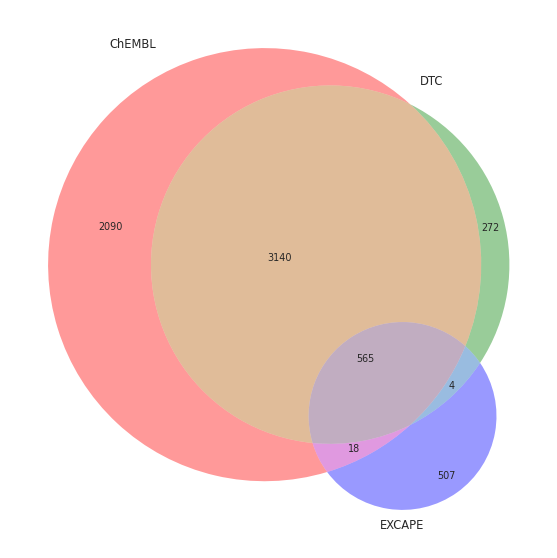

In [91]:
mpv.venn3([set(chembl.base_rdkit_smiles),
           set(dtc.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

That's more like it. For even further overlaps, it's possible to pass all of them through the pubchem ID exchange: use input as smiles and output as smiles, then create base_rdkit_smiles again. You should see some increase in overlap with this pre-processing step.

# EDA: Examine compound diversity

 If you want to restart, you can start from here. Please uncomment the following code chunk 

In [92]:
# chembl=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_ChEMBL_SMILES_std.csv", index_col=0)
# dtc=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_DTC_SMILES_std.csv", index_col=0)
# excape=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_Excape_SMILES_std.csv", index_col=0)

In [93]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat

import umap
from scipy.stats.kde import gaussian_kde
from scipy.cluster.hierarchy import linkage

ndist_max = 1000000

def plot_tani_dist_distr(dataset, smiles_col, dataset_name, **metric_kwargs):
    """
    Generate a density plot showing the distribution of distances between ecfp feature
    vectors, using the tanimoto metric.
    """
    # log = logging.getLogger('ATOM')
    num_cmpds = len(dataset)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    # log.warning("Starting distance matrix calculation for %d compounds" % num_cmpds)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    smiles_arr1 = dataset[smiles_col].values
    mols1 = [Chem.MolFromSmiles(s) for s in smiles_arr1]
    fprints1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in mols1]
    dists = GetTanimotoDistMat(fprints1)

    # log.warning("Finished calculation of %d distances" % len(dists))

    if len(dists) > ndist_max:
        # Sample a subset of the distances so KDE doesn't take so long
        dist_sample = np.random.choice(dists, size=ndist_max)
    else:
        dist_sample = dists

    dist_pdf = gaussian_kde(dist_sample)
    x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
    y_plt = dist_pdf(x_plt)
    fig, ax = plt.subplots(figsize=(8.0,8.0))
    ax.plot(x_plt, y_plt)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
                  dataset_name, dist_metric, feat_type))
    return dists


In [94]:
sns.set_context('poster')

array([0.43283582, 0.90625   , 0.95121951, ..., 0.89041096, 0.87804878,
       0.74444444])

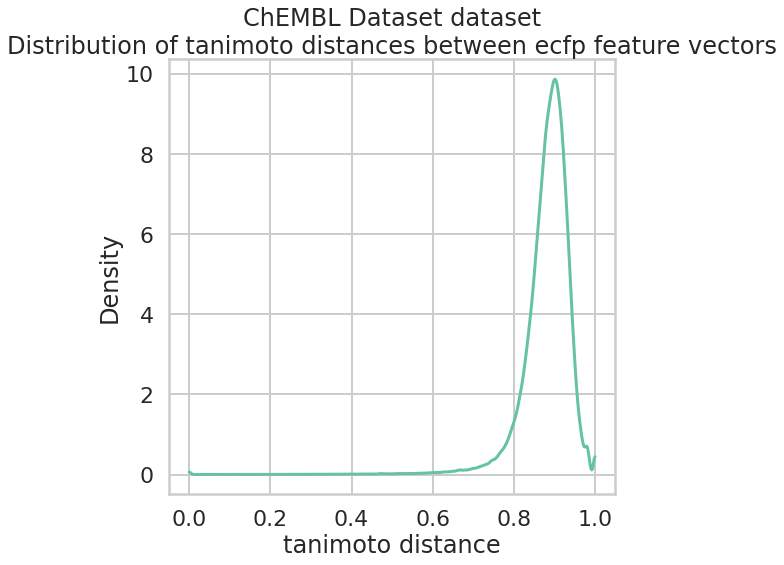

In [95]:
plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [96]:
chembl[['Molecule_ChEMBL_ID','base_rdkit_smiles','pChEMBL_Value']].head(3)

,Molecule_ChEMBL_ID,base_rdkit_smiles,pChEMBL_Value
0,CHEMBL4283189,CCN(CC)CCOC(=O)/C=C/c1ccc2oc(C(=O)Nc3cccc(Cl)c...,NaN
1,CHEMBL4279249,O=C(O)/C=C/c1ccc2oc(C(=O)Nc3ccccc3)cc(=O)c2c1,NaN
2,CHEMBL4300905,CCC(C)(C)c1ccc(OCCCCN2CCCC(C)C2)cc1,NaN


In [100]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/MAOA_ChEMBL_SMILES_std.csv',
                   id_col ='Molecule_ChEMBL_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True)

Exception: ignored

## Create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

In [101]:
dtc['base_rdkit_smiles']

0       C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
1       C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
2                                       NCCCNCCSP(=O)(O)O
3                                       NCCCNCCSP(=O)(O)O
4                          N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O
                              ...                        
6556                         O=C1/C(=C/c2ccsc2)Cc2ccccc21
6557    Cc1ccc(NC(=O)CCC(=O)OCC(=O)c2ccc(-c3ccccc3)cc2...
6558                      N#Cc1ccc(Oc2ccc3ccccc3c2)cc1C#N
6559                         CC(=O)N1CCC(c2ccc(Cl)cc2)=N1
6560                       COc1ccc(C2=NN(c3ccccc3)CC2)cc1
Name: base_rdkit_smiles, Length: 6488, dtype: object

In [102]:
# Because we made some changes to DTC. We need to get the std SMILES again

In [103]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_DTC_SMILES_std.csv")

In [104]:
dtc=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_DTC_SMILES_std.csv", index_col=0)

In [105]:
dtc.head()

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles
0,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484105,DTCC00132413,2089752,46191,NaN,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
1,CHEMBL10,P21397,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7484106,DTCC00132413,2089752,46191,NaN,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
2,CHEMBL1006,P21397,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7291225,DTCC00224760,898282,46191,NaN,C(CN)CNCCSP(=O)(O)O,NCCCNCCSP(=O)(O)O
3,CHEMBL1006,P21397,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7291226,DTCC00224760,898282,46191,NaN,C(CN)CNCCSP(=O)(O)O,NCCCNCCSP(=O)(O)O
4,CHEMBL1009,P21397,LEVODOPA,WTDRDQBEARUVNC-LURJTMIESA-N,4,MONOAMINE OXIDASE A,MAOA,Enzyme,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BTI-TN-5B1-4,DRUGMATRIX: Monoamine Oxidase MAO-A enzyme inh...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrixÂ¨ and ToxFXÂ¨ Co...",NaN,774648.0,DTCT0023168,7425187,DTCC00224903,1351112,46191,NaN,C1=CC(=C(C=C1C[C@@H](C(=O)O)N)O)O,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O


array([0.        , 1.        , 1.        , ..., 0.84285714, 0.82352941,
       0.66666667])

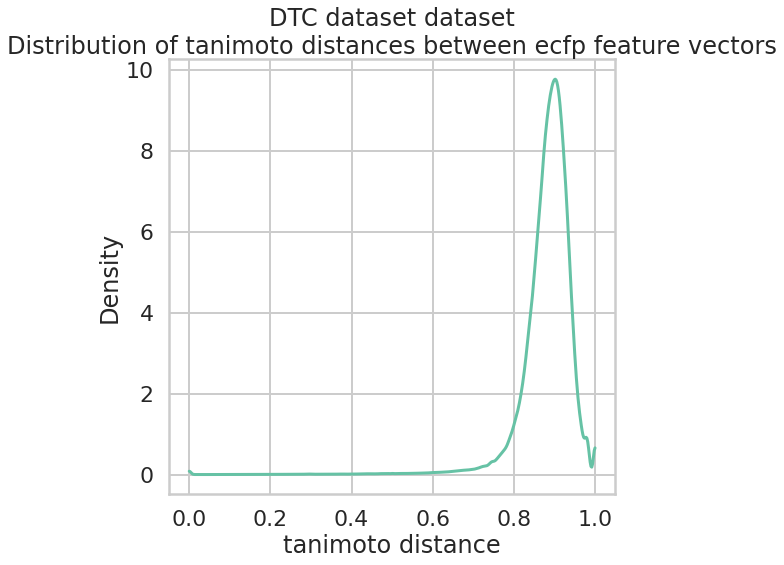

In [106]:
plot_tani_dist_distr(dtc, 'base_rdkit_smiles', 'DTC dataset') # check for NA or other types

In [107]:
dtc[['Compound_ID','base_rdkit_smiles','pDTC_Value']]

,Compound_ID,base_rdkit_smiles,pDTC_Value
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,NaN
1,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,NaN
2,CHEMBL1006,NCCCNCCSP(=O)(O)O,NaN
3,CHEMBL1006,NCCCNCCSP(=O)(O)O,NaN
4,CHEMBL1009,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,NaN
...,...,...,...
6556,NaN,O=C1/C(=C/c2ccsc2)Cc2ccccc21,5.821023
6557,NaN,Cc1ccc(NC(=O)CCC(=O)OCC(=O)c2ccc(-c3ccccc3)cc2...,3.164309
6558,NaN,N#Cc1ccc(Oc2ccc3ccccc3c2)cc1C#N,5.296709
6559,NaN,CC(=O)N1CCC(c2ccc(Cl)cc2)=N1,8.000000


In [108]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/MAOA_DTC_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Compound_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pDTC_Value')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


AttributeError: ignored

In [109]:
plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'Excape_dataset')

TypeError: ignored

In [110]:
excape.columns


Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES', 'base_rdkit_smiles'],
      dtype='object')

In [111]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/MAOA_Excape_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Original_Entry_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

TypeError: ignored

## Discussion on the analysis of the heatmap and density plots
```
what are Morgan fingerprints (ecfp)? 
what does radius mean?
what does a bit in an ECFP vector correspond to?
what radius and vector length are used in these functions?
hint: look at the .py files for more info
```
ECFP fingerprints are a bit vector representation of a compound's structure. Each bit represents the presence or absence of a certain 'connectivity' between atoms in a molecule. The radius used in the diversity plots function is radius 4 and length 1024. The tanimoto plot function uses radius 2. Radius means number of atoms you travel away from the given atom to assess connectivity, allowing you to look at larger or smaller molecule fragments.


```
what is tanimoto distance? What do values closer to zero or closer to one mean?
Do you think your sets of compounds are diverse?
What do you observe from the 2D projection of compounds?
Are there any similarities between groups of compounds in your datasets?
```

Tanimoto similarity (or jaccard index) represents how well two bit vectors overlap. Thus, distance represents how 'far' away they are from perfect overlap. A distance closer 1 means the fingerprints (and therefore molecules) are less similar to each other. A distance closer to zero means molecules are more similar. 

Compounds that are shown in this exercise have average tanimoto distances ~ 0.85 - 0.9, so they are fairly diverse.

In the ChEMBL dataset, the 2D project separates high and low pChEMBL values very well. The DTC and Excape datasets don't separate as well, but DTC also is on a very different scale.

From the heatmap, we can see clusters/squares of compounds with tanimoto distance closer to zero (purple) so I suspect there are some groups of compounds that are very similar.


# EDA: Curated data
- First let us curate the data
- Examine new compound overlaps
- Examine final response column distributions
- Filter for 
  - large compounds
  - too high / too low pXC50 values
- double check for no NA values left
- save final curated dataset for further processing

Start here if you want to restart from here. Dont forget to uncomment the following code chunk

In [112]:
chembl=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_ChEMBL_SMILES_std.csv", index_col=0)
dtc=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_DTC_SMILES_std.csv", index_col=0)
excape=pd.read_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_Excape_SMILES_std.csv", index_col=0)

In [113]:
# rescue NA pChemblValues
chembl['pChEMBL_Value_nM'] = -np.log10(chembl.Standard_Value_nM/1000000000)


In [114]:
chembl.head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles,pChEMBL_Value_nM
0,CHEMBL4283189,NaN,0.0,468.94,0.0,4.60,12b,CCN(CC)CCOC(=O)/C=C/c1ccc2oc(C(=O)Nc3cccc(Cl)c...,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4268516,Inhibition of human recombinant microsomal MAO...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4265951,1,Scientific Literature,Eur J Med Chem,2018.0,NaN,NaN,NaN,CCN(CC)CCOC(=O)/C=C/c1ccc2oc(C(=O)Nc3cccc(Cl)c...,NaN
1,CHEMBL4279249,NaN,0.0,335.32,0.0,3.14,29,O=C(O)/C=C/c1ccc2oc(C(=O)Nc3ccccc3)cc(=O)c2c1,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4268516,Inhibition of human recombinant microsomal MAO...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4265951,1,Scientific Literature,Eur J Med Chem,2018.0,NaN,NaN,NaN,O=C(O)/C=C/c1ccc2oc(C(=O)Nc3ccccc3)cc(=O)c2c1,NaN
2,CHEMBL4300905,NaN,0.0,317.52,1.0,5.27,14,CCC(C)(C)c1ccc(OCCCCN2CCCC(C)C2)cc1,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4329063,Inhibition of human MAO-A expressed in baculov...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL1951,Monoamine oxidase A,Homo sapiens,SINGLE PROTEIN,CHEMBL4325892,1,Scientific Literature,Bioorg Med Chem Lett,2018.0,NaN,NaN,NaN,CCC(C)(C)c1ccc(OCCCCN2CCCC(C)C2)cc1,NaN


In [115]:
chembl.Standard_Type.unique()

array(['Inhibition', 'IC50', 'Kinact', 'Ki', 'Activity', 'Km', 'Vmax',
       'Ratio', 'FC', 'Ratio IC50', 'k cat', 'k cat/Km', 'TN', 'K inact',
       'TDI', 'KiA', 'Vmax / Km', '% Ctrl', 'Ri', 'EC50'], dtype=object)

In [116]:
# select pIC50 values
vals = ['EC50', 'IC50', 'pIC50']
print(chembl.shape)
chembl=chembl[chembl.Standard_Type.isin(vals)]
print(chembl.shape)

(8430, 48)
(4602, 48)


In [118]:
# drop NA pIC50's & smiles
chembl=chembl.dropna(axis=0, subset = ['pChEMBL_Value_nM','base_rdkit_smiles'])
print(chembl.shape)

(3485, 48)


In [119]:
# note weird punctuation
chembl.Standard_Relation.unique()

array(["'='", "'>'", "'<'", "'>='"], dtype=object)

In [120]:
# flip arrows and fix punctuation for relation column to reflect pValues not normal values
chembl['pRelation'] = chembl.Standard_Relation
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'<'", ">", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'>'", "<", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'='", "=", chembl.pRelation)
chembl[['Standard_Relation', 'pRelation']].head()

,Standard_Relation,pRelation
3,'=',=
6,'=',=
7,'>',<
8,'>',<
9,'=',=


In [121]:
thresh=-np.log10(100/1000000000) # pIC50 of 100nM for threshold

In [122]:
print(chembl.shape)
chembl_cur = curate_data.aggregate_assay_data(chembl, value_col = 'pChEMBL_Value_nM', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Molecule_ChEMBL_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
print(chembl_cur.shape)
chembl_cur.head()

(3485, 49)
0 entries in input table are missing SMILES strings
2910 unique SMILES strings are reduced to 2910 unique base SMILES strings
(2910, 5)


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL4062892,Cc1cccc(/N=N/c2ccc(C3=NNC(=O)CO3)cc2)c1,<,4.000000,0
1,CHEMBL3415781,C#CCN(C)CC(=C)c1cccc(OCc2ccc(OC)cc2)c1,,7.301030,1
2,CHEMBL3288297,O=C1CCCc2cc(OCc3ccc(Br)cc3)ccc21,,6.507240,0
3,CHEMBL3651132,COc1ccc2ccccc2c1CN[C@H]1CC1c1ccccc1,,4.785156,0
4,CHEMBL4447614,Nc1n[nH]c(NCc2ccccc2Oc2ccccc2)n1,,4.299296,0


In [123]:
chembl_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_ChEMBL_cur.csv")

In [124]:
# DTC
# select pIC50 values
vals = ['EC50', 'IC50', 'PIC50']
print(dtc.shape)
dtc=dtc[dtc.End_Point_Standard_Type.isin(vals)]
print(dtc.shape)

# flip arrows for relation column to reflect pValues not normal values
dtc['pRelation'] = dtc.End_Point_Standard_Relation
dtc['pRelation'] = np.where(dtc.End_Point_Standard_Relation == "<", ">", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.End_Point_Standard_Relation == ">", "<", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.End_Point_Standard_Relation == "=", "=", dtc.pRelation)
print(dtc.pRelation.unique())
display(dtc[['End_Point_Standard_Relation', 'pRelation']].head())

dtc=dtc.dropna(axis=0, subset = ['pDTC_Value','base_rdkit_smiles'])
print(dtc.shape)

(6488, 46)
(3445, 46)
[nan '=' '<' '>' '>=']


,End_Point_Standard_Relation,pRelation
0,NaN,NaN
2,NaN,NaN
4,NaN,NaN
6,NaN,NaN
8,NaN,NaN


(2488, 47)


In [125]:
dtc.pDTC_Value.fillna('')
dtc.base_rdkit_smiles.fillna('')

18                             c1ccc2c(c1)OCC(C1=NCCN1)O2
19                             c1ccc2c(c1)OCC(C1=NCCN1)O2
20                             c1ccc2c(c1)OCC(C1=NCCN1)O2
35                            O=C1NC(=O)C(Cc2ccc(O)cc2)S1
42                                COC1=CC(=O)c2ccccc2C1=O
                              ...                        
6556                         O=C1/C(=C/c2ccsc2)Cc2ccccc21
6557    Cc1ccc(NC(=O)CCC(=O)OCC(=O)c2ccc(-c3ccccc3)cc2...
6558                      N#Cc1ccc(Oc2ccc3ccccc3c2)cc1C#N
6559                         CC(=O)N1CCC(c2ccc(Cl)cc2)=N1
6560                       COc1ccc(C2=NN(c3ccccc3)CC2)cc1
Name: base_rdkit_smiles, Length: 2488, dtype: object

In [126]:
dtc['pDTC_Value'].isnull()

18      False
19      False
20      False
35      False
42      False
        ...  
6556    False
6557    False
6558    False
6559    False
6560    False
Name: pDTC_Value, Length: 2488, dtype: bool

In [128]:
dtc_cur = curate_data.aggregate_assay_data(dtc, value_col = 'pDTC_Value', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Compound_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)

dtc_cur.to_csv("/content/DTC_cur.csv")

0 entries in input table are missing SMILES strings
1816 unique SMILES strings are reduced to 1816 unique base SMILES strings


TypeError: ignored

In [127]:
# aggregate duplicatesss
dtc_cur = curate_data.aggregate_assay_data(dtc, value_col = 'pDTC_Value', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Compound_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
dtc_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_DTC_cur.csv")
print(dtc_cur.shape)
print(dtc_cur.relation.unique())
dtc_cur.head()

0 entries in input table are missing SMILES strings
1816 unique SMILES strings are reduced to 1816 unique base SMILES strings


TypeError: ignored

In [129]:
# excape: has no relation col, so create one with all ''
excape['pRelation']=''
print(excape.shape)
print(excape.pRelation.unique())
excape=excape.dropna(axis=0, subset = ['pXC50','base_rdkit_smiles'])
print(excape.shape)
# aggregate duplicates
excape_cur = curate_data.aggregate_assay_data(excape, value_col = 'pXC50', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Original_Entry_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
excape_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_Excape_cur.csv")
print(excape_cur.shape)
print(excape_cur.relation.unique())
excape_cur.head()

(1126, 13)
['']
(1107, 13)
0 entries in input table are missing SMILES strings
1075 unique SMILES strings are reduced to 1075 unique base SMILES strings
(1075, 5)
['']


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,50994008,Cc1nccc2c1[nH]c1cc(OCCCC(F)(F)F)ccc12,,8.4437,1
1,CHEMBL568385,CCOC(=O)c1cc2ccc(OC)cc2oc1=O,,3.8200,0
2,CHEMBL291388,CCOc1ccc2c(c1)S(=O)(=O)c1ccccc1O2,,7.4000,1
3,CHEMBL3288297,O=C1CCCc2cc(OCc3ccc(Br)cc3)ccc21,,6.5100,0
4,CHEMBL127880,O=C1c2ccccc2-c2nncc(-c3ccccc3)c21,,4.4600,0


In [130]:
chembl_cur['datasource'] = 'chembl'
dtc_cur['datasource']='dtc'
excape_cur['datasource']='excape'
HTR3A = pd.concat([chembl_cur, dtc_cur, excape_cur])
HTR3A.to_csv("/content/drive/MyDrive/Columbia_E4511/MAOA_merge.csv")
print(HTR3A.shape)

NameError: ignored

In [ ]:
import importlib
importlib.reload(curate_data)
MAOA_cur = curate_data.aggregate_assay_data(MAOA, value_col = 'pXC50', 
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'relation',
                                              active_thresh=thresh)

print(MAOA_cur.shape)
print(MAOA.relation.unique())
MAOA_cur.head()

In [ ]:
MAOA_cur.relation.unique()

In [ ]:
HTR3A_cur.pXC50.hist(figsize=(5,5));

In [ ]:
HTR3A_cur.active.sum()

In [ ]:
mpv.venn3([set(HTR3A.loc[HTR3A.datasource=='chembl','base_rdkit_smiles']),
           set(HTR3A.loc[HTR3A.datasource=='dtc','base_rdkit_smiles']),
           set(HTR3A.loc[HTR3A.datasource=='excape','base_rdkit_smiles']),],
          set_labels = ['ChEMBL','DTC','Excape']);

In [ ]:
HTR3A_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in HTR3A_cur["base_rdkit_smiles"]]
HTR3A_cur = HTR3A_cur.sort_values('mol_wt')
HTR3A_cur=HTR3A_cur.reset_index(drop=True)
HTR3A_cur=HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(10,5))
HTR3A_cur.plot(kind='scatter', x='index', y='mol_wt', ax=ax);
plt.title("Distribution of molecular weights");

In [ ]:
print(HTR3A_cur.shape)
HTR3A_cur = HTR3A_cur[HTR3A_cur.mol_wt <1400]
print(HTR3A_cur.shape)

In [ ]:
HTR3A_cur=HTR3A_cur.drop(columns=['index'])
HTR3A_cur = HTR3A_cur.sort_values('pXC50')
HTR3A_cur = HTR3A_cur.reset_index(drop=True)
HTR3A_cur = HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HTR3A_cur.plot(kind='scatter', x='index', y='pXC50', ax=ax);
plt.title("Distribution of pXC50 values");

In [ ]:
print(HTR3A_cur.shape)
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50>2]
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50<14]
print(HTR3A_cur.shape)

In [ ]:
for col in HTR3A_cur.columns:
  print(col, HTR3A_cur[col].isna().values.any())

In [ ]:
plot_tani_dist_distr(HTR3A_cur, 'base_rdkit_smiles', 'HTR3A Merged & Curated Dataset')

In [ ]:
HTR3A_cur.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv")

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50',
                   ecfp_radius = 2)

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50',
                   ecfp_radius = 6)

The following code takes too long. Try only when you are running this
on a dedicated server

In [ ]:
# warning: 1000 doesn't work, takes too long
importlib.reload(dp)
# dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_cur.csv', 
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50', 
#                    max_for_mcs=1100)

# Now you're ready to move on to the next stage of EDA & modeling: featurizing datasets
- featurize with structure-based fingerprints like ECFP
- or molecular descriptor sets like RDKit and Mordred
- these are high - dimensional datasets (200-2000 features or 'dimensions')
- so UMAP, tSNE and other dimensionality reduction techniques will help visualize the 'chemical space' of the dataset